In [1]:
# Data stuff
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

# Dask
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

# Prepa data-set for models

In [2]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_KNN_entire/*.part')
# Ensure correct types
dataset = dataset.astype(dtype={
    'gender':int,
    'ethnicity_AMERICAN INDIAN/ALASKA NATIVE':int,
    'ethnicity_ASIAN':int,
    'ethnicity_BLACK/AFRICAN AMERICAN':int,
    'ethnicity_HISPANIC/LATINO':int,
    'ethnicity_WHITE':int,
    'insurance_Medicaid':int,
    'insurance_Medicare':int,
    'marital_status_DIVORCED':int,
    'marital_status_MARRIED':int,
    'marital_status_SINGLE':int,
    'marital_status_WIDOWED':int,
    'language_english':int,
    'hospital_expire_flag':int,
})
# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

In [3]:
# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values

# dataset as is, but target variable dropped(hospital expire flag)
dataset_no_target = dataset.drop(columns=['hospital_expire_flag'])

# Feture names and categorical feature names
feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() + dataset_no_target.select_dtypes(exclude='int').columns.values.tolist() 
cat_feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() 

# Generate data set with categories(int type required)
dataframe_int_list = dataset_no_target.select_dtypes(include='int').values.tolist()
dataframe_no_int_list = dataset_no_target.select_dtypes(exclude='int').values.tolist()
Y = dataset.hospital_expire_flag.values.tolist()
X = []
for i,v in enumerate(dataframe_int_list):
    X = X + [v+dataframe_no_int_list[i]]

# Generate categorical feature indicies
cat_features_indices=list(range(0,len(dataframe_int_list[0])))

# Define functions and variables

In [4]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    folds = 3
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = rand_state)
    
    # Perform fit and scoring
    if uses_cat:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X, Y),random_state = rand_state, refit=True, verbose=3,  )
        random_search.fit(X, Y)     
    else:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
        random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

# Scale of negative class to the positive class(#survived/#died)
scale_pos_weight_min = int( (dataset[dataset.hospital_expire_flag==0].shape[0] / dataset[dataset.hospital_expire_flag==1].shape[0]) )

# Models

## Random Forest

In [11]:
RF_classifier =  RandomForestClassifier(class_weight='balanced')
RF_params = {
        'max_depth': (3,4,5,6,7,10,15,20,25),
        'n_estimators': (1,5,10,25,50,100),
        'criterion':['gini','entropy'],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'bootstrap': [False,True],
        'class_weight':[None, 'balanced_subsample','balanced']
}
model = strat_cv_it(RF_classifier ,RF_params,False, 50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   30.4s finished


0.8223752783097048

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': True}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.987026      0.018753         0.033578    9.404929e-04   
1        0.169545      0.012720         0.008312    4.704150e-04   
2        0.412896      0.004533         0.014628    9.395938e-04   
3        0.229386      0.003550         0.008976    5.150430e-07   
4        0.031914      0.002155         0.004654    9.399871e-04   
5        0.115025      0.008553         0.006649    4.704162e-04   
6        2.475710      0.022006         0.054189    1.243879e-03   
7        0.170876      0.000470         0.009641    1.695186e-03   
8        1.828774      0.023266         0.053191    2.487609e-03   
9        0.093748      0.002154         0.006982    8.144907e-04   
10       1.171864      0.008809         0.034907    1.410683e-03   
11       0.036568      0.001695         0.003990    7.370010e-07   
12       0.951122      0.004017         0.033578    1.243964e-03   
13       1.735025      0.023109         0.051861    2.154830e-03   
14       0.354718      0.007344         0.017287    4.704153e-04   
15       0.042885      0.002154         0.003990    2.247832e-07   
16       0.553852      0.025182         0.024934    5.641609e-03   
17       0.421206      0.021303         0.028591    8.356483e-03   
18       0.887625      0.035467         0.034907    2.154646e-03   
19       5.224357      0.022365         0.103391    5.172486e-03   
20       0.046209      0.000470         0.003989    4.899036e-07   
21       0.228056      0.007697         0.010638    3.760679e-03   
22       0.666217      0.075732         0.019615    1.243964e-03   
23       0.172870      0.000470         0.007647    4.703595e-04   
24       0.812160      0.008707         0.028591    1.244474e-03   
25       0.071808      0.002936         0.005984    8.142963e-04   
26       0.606045      0.010182         0.021276    2.617697e-03   
27       0.127658      0.006463         0.009973    4.231038e-03   
28       1.854040      0.034673         0.063497    5.543466e-03   
29       0.043550      0.004484         0.005319    4.702468e-04   
30       0.211102      0.017866         0.009640    1.695061e-03   
31       0.191155      0.005235         0.009974    8.137123e-04   
32       0.198470      0.005340         0.007978    8.142964e-04   
33       0.101396      0.004976         0.006649    9.400433e-04   
34       0.045545      0.003672         0.004654    4.705277e-04   
35       0.173535      0.005873         0.008312    4.699655e-04   
36       0.058842      0.001410         0.004988    8.135174e-04   
37       0.050199      0.002049         0.004988    1.140650e-06   
38       0.040890      0.001410         0.005652    1.695077e-03   
39       0.210770      0.014665         0.012965    3.549122e-03   
40       0.360036      0.003732         0.011303    4.706962e-04   
41       0.076130      0.004017         0.006317    4.703026e-04   
42       3.475701      0.010203         0.106050    8.707705e-03   
43       4.105350      0.077357         0.107380    2.487015e-03   
44       0.332776      0.002618         0.014295    4.703027e-04   
45       0.065824      0.002442         0.004655    4.713142e-04   
46       0.380316      0.003391         0.015292    1.244601e-03   
47       0.368680      0.005891         0.016622    4.701342e-04   
48       2.045860      0.040078         0.053524    1.880705e-03   
49       1.293872      0.013875         0.047540    1.694921e-03   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                  50                      10                      2   
1                   5                       5                      4   
2                  10                      10                      4   
3                  10                       5                      4   
4                   1                       5                      4   
5                   5                       5                      1   
6                  50          

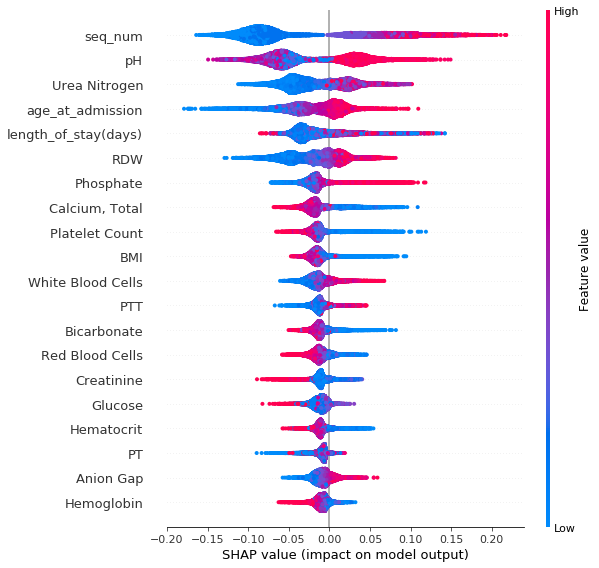

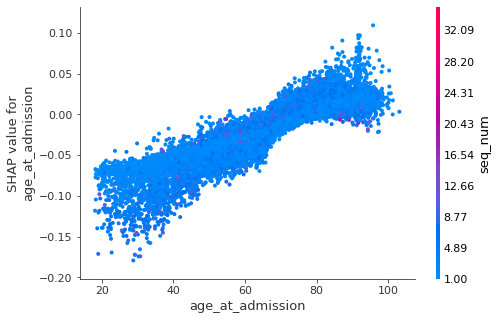

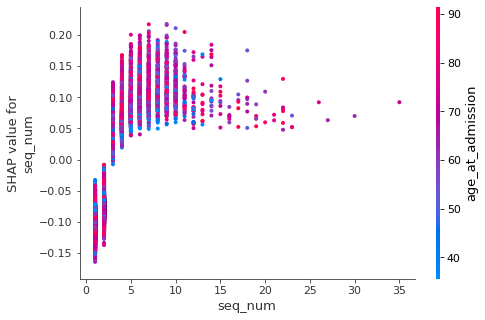

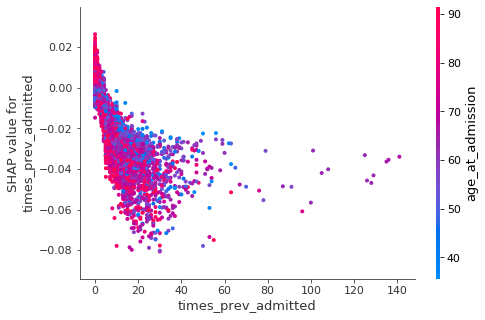

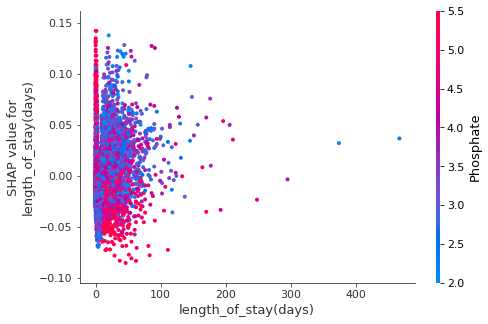

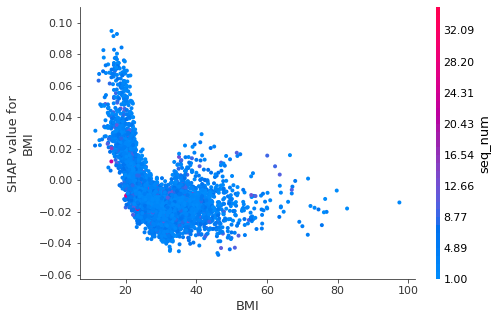

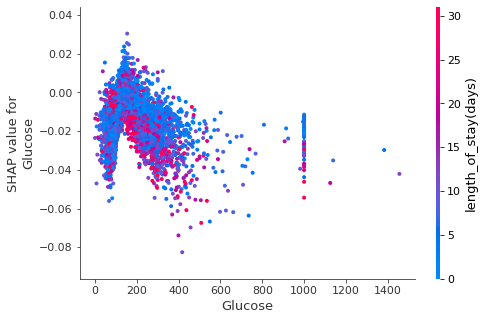

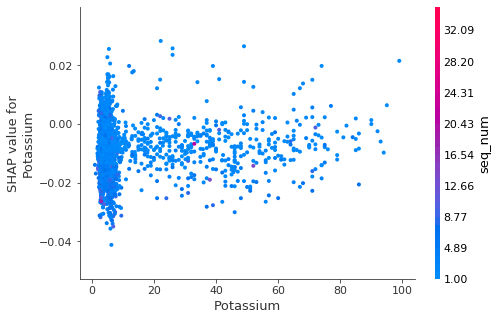

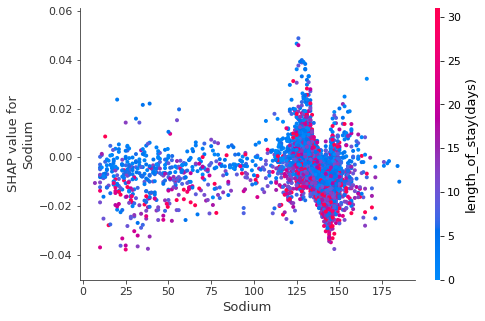

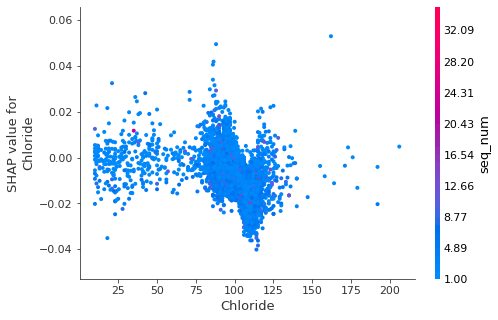

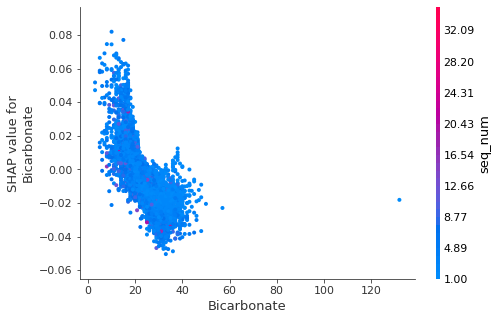

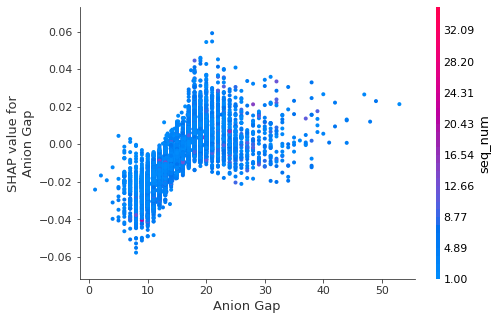

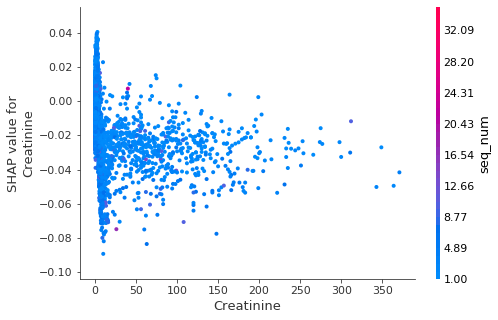

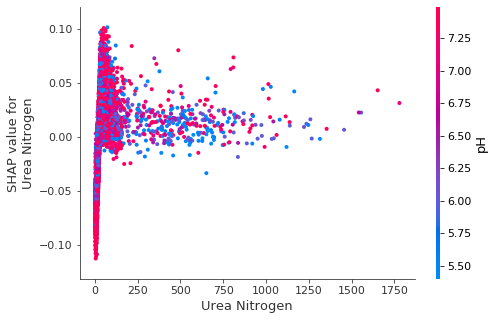

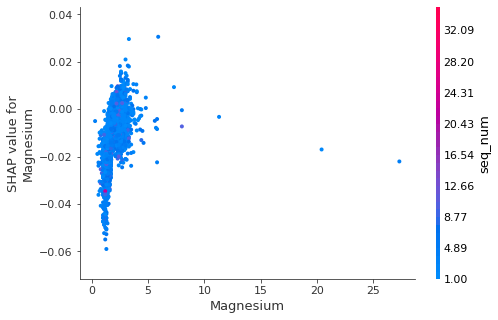

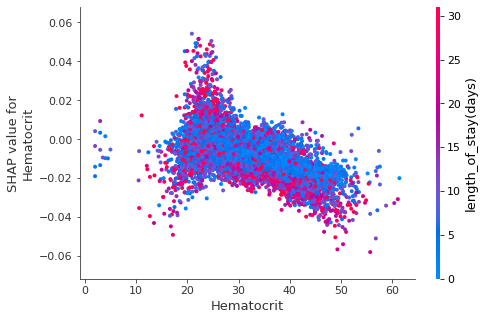

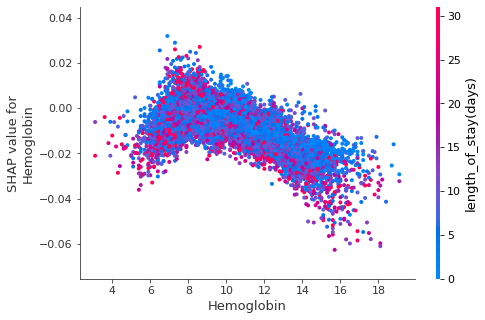

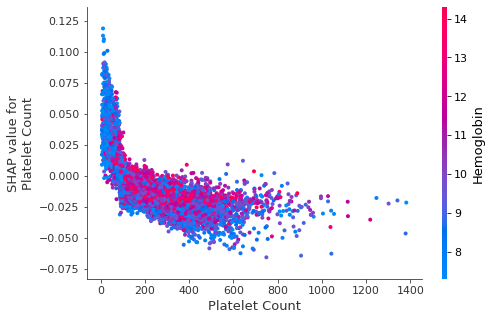

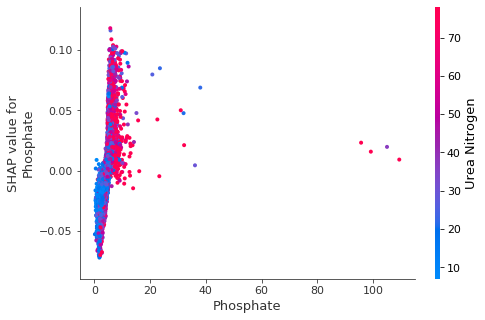

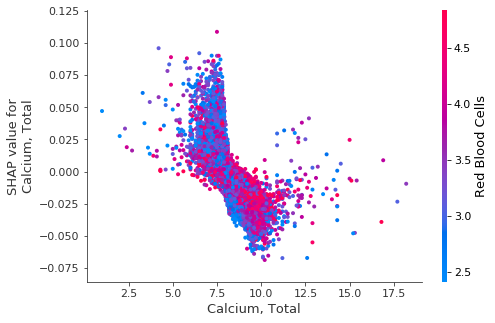

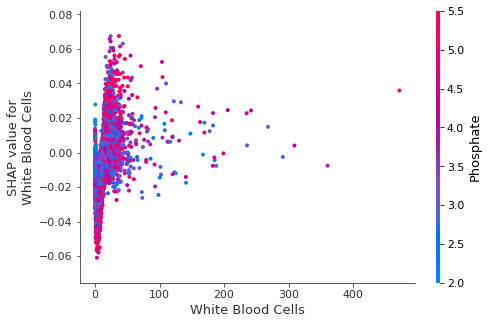

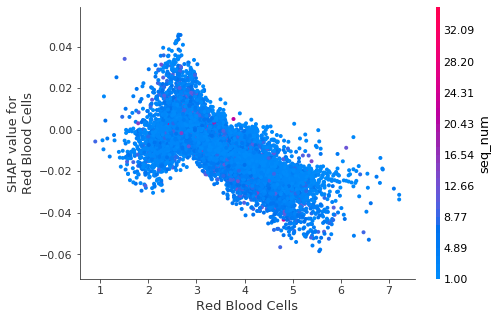

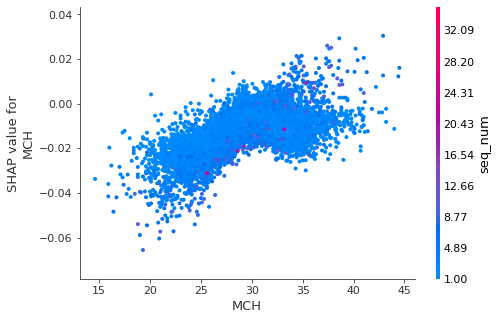

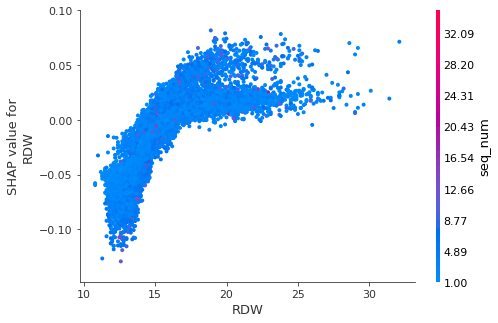

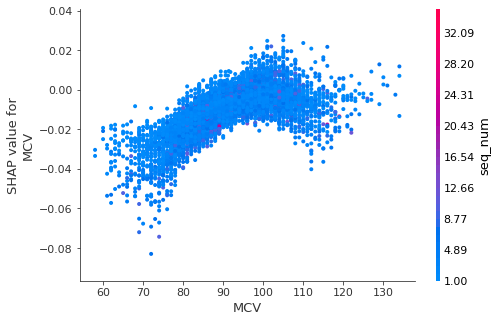

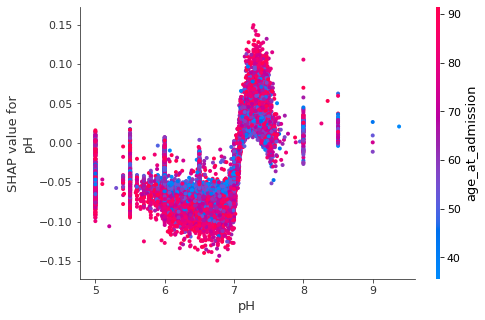

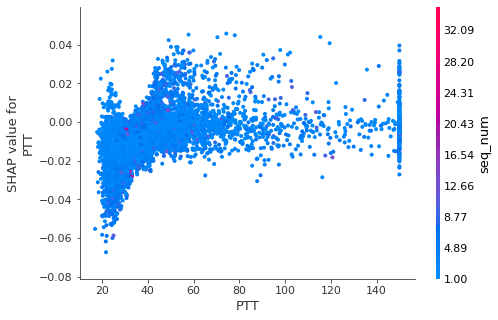

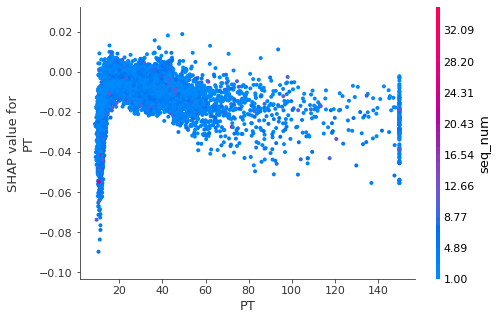

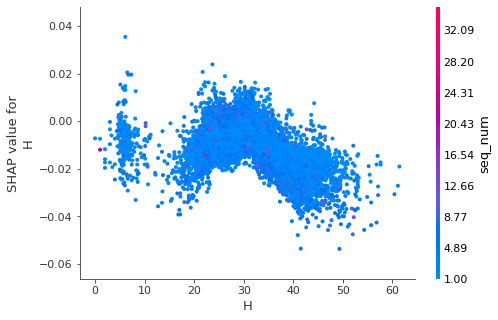

In [12]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values[1],X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1],X_no_cat ,feature_names=feature_names)

## XGBOOST

In [5]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = {
        'learning_rate': (0.01, 0.05,0.1),
        'min_child_weight': [3, 5, 10],
        'gamma': [0.5, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': list(range(5,30)),
        'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   53.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  4.7min finished


0.8296318207338501

{'subsample': 0.8,
 'scale_pos_weight': 18,
 'min_child_weight': 10,
 'max_depth': 16,
 'learning_rate': 0.05,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       10.216683      0.391308         0.133975        0.018106   
1        5.341844      0.016317         0.104223        0.011595   
2        4.239047      0.051444         0.104556        0.005026   
3       10.909675      0.101868         0.126982        0.003071   
4        9.239535      0.015040         0.111084        0.001846   
5        8.004356      0.187812         0.096324        0.003956   
6        8.524026      0.092963         0.099733        0.009391   
7        7.204357      0.014346         0.124334        0.005719   
8        6.277134      0.005809         0.111443        0.004605   
9        6.936288      0.139471         0.135173        0.007402   
10       9.360618      0.063610         0.144587        0.022096   
11      10.144186      0.115397         0.113934        0.003683   
12       5.922361      0.131140         0.117070        0.002419   
13       8.027156      0.101212         0.104411        0.003705   
14       7.167762      0.094522         0.103897        0.003672   
15       4.559832      0.019553         0.080115        0.004914   
16       6.408923      0.015609         0.119347        0.007389   
17       8.878284      0.089950         0.132978        0.004072   
18       6.333936      0.057183         0.137481        0.013460   
19       5.753127      0.093156         0.105112        0.006636   
20       7.149526      0.072201         0.100992        0.004144   
21       2.106403      0.024648         0.040765        0.002704   
22       4.682704      0.051256         0.109482        0.003685   
23       7.940464      0.117353         0.120731        0.001437   
24       7.945100      0.155338         0.117522        0.010732   
25       2.241197      0.102103         0.048392        0.012009   
26       9.648189      0.342854         0.096742        0.010772   
27       9.162156      0.030603         0.152925        0.030571   
28       5.857663      0.191367         0.129986        0.019902   
29       8.777851      0.114932         0.119015        0.009403   
30       3.956083      0.075387         0.065823        0.003549   
31       3.035547      0.030012         0.066488        0.001695   
32       7.382916      0.050674         0.113364        0.006003   
33       7.386906      0.074729         0.122339        0.018875   
34       7.564763      0.260413         0.161236        0.031011   
35       9.279176      0.081810         0.137965        0.007697   
36       9.245600      0.075518         0.128324        0.008969   
37      10.181097      0.509408         0.106714        0.002155   
38       8.961693      0.280421         0.113031        0.003291   
39       2.757290      0.049802         0.075132        0.002050   
40       7.744549      0.298075         0.125664        0.003732   
41       2.756646      0.053850         0.054854        0.003731   
42       2.535341      0.070931         0.073470        0.001880   
43       8.869687      0.189221         0.233545        0.035572   
44      10.385726      0.188670         0.164729        0.039292   
45       8.047081      0.615942         0.137299        0.023238   
46       6.346705      0.089961         0.113364        0.015067   
47       7.323129      0.027786         0.105717        0.004953   
48       6.966696      0.385615         0.131980        0.007566   
49       5.007271      0.093055         0.067486        0.002049   

   param_subsample param_scale_pos_weight param_min_child_weight  \
0                1                     20                     10   
1              0.6                      9                     10   
2                1                     22                     10   
3                1                     12                      3   
4              0.6                     22                      5   
5                1                     15                      5   
6              0.6                     12                  

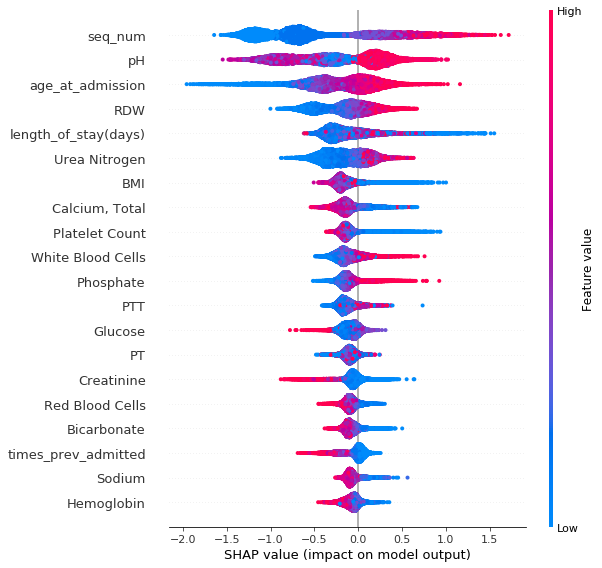

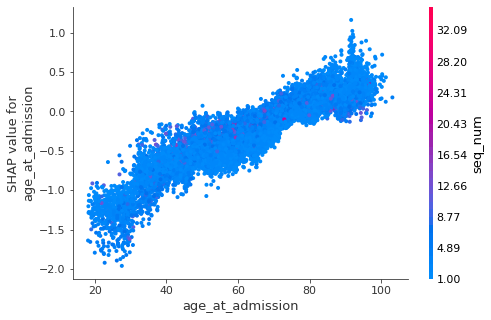

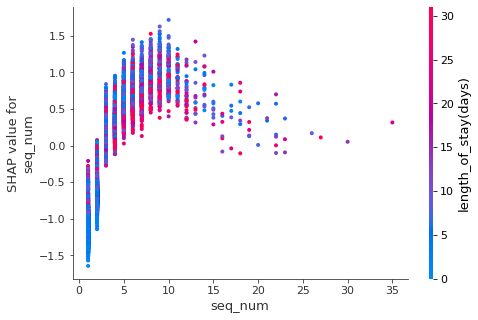

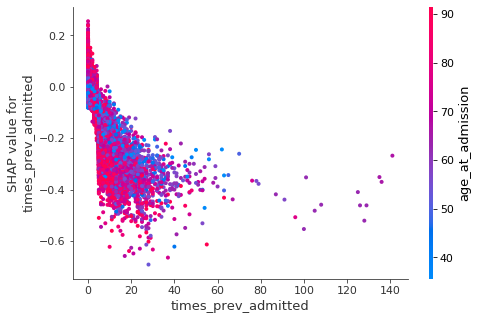

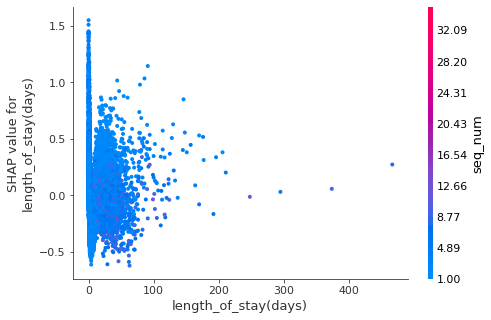

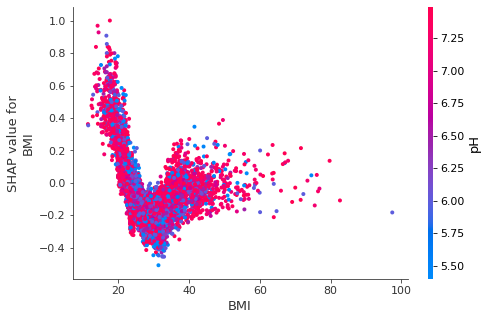

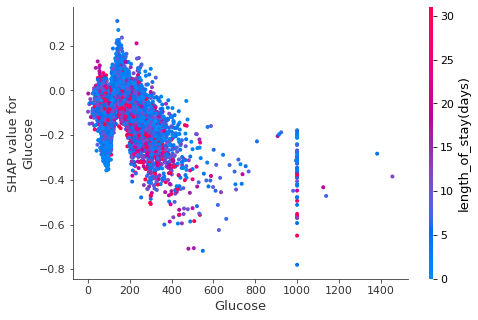

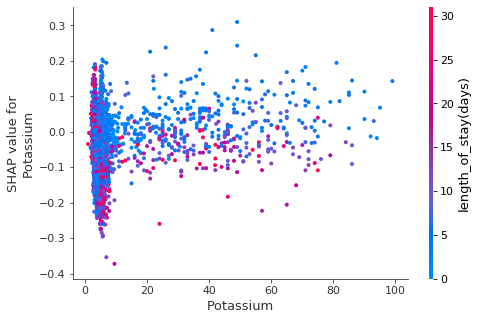

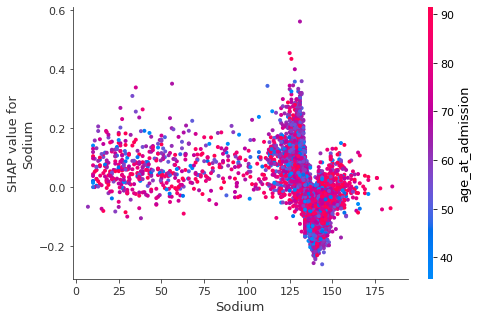

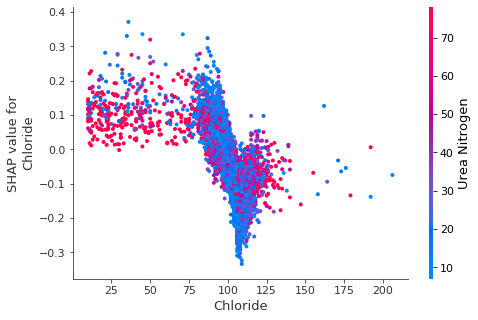

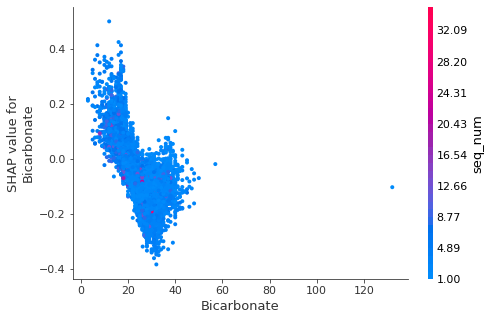

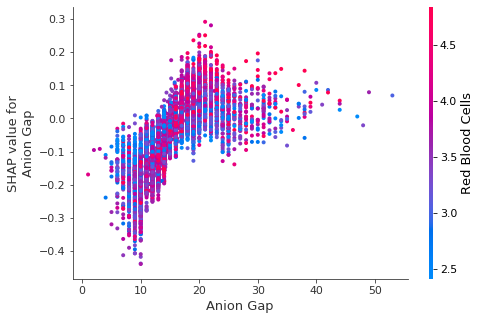

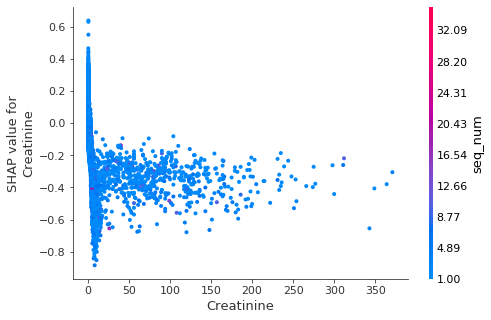

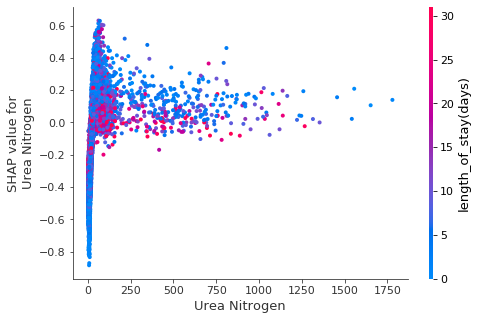

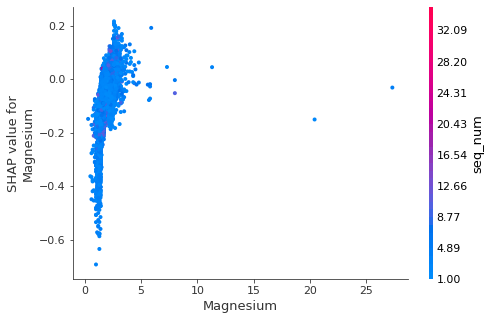

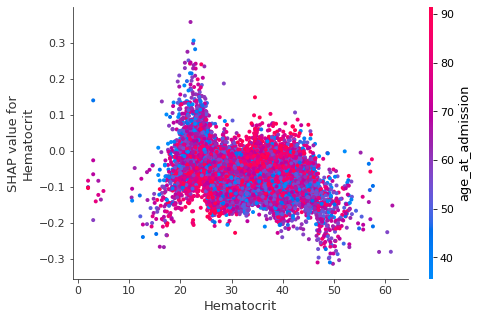

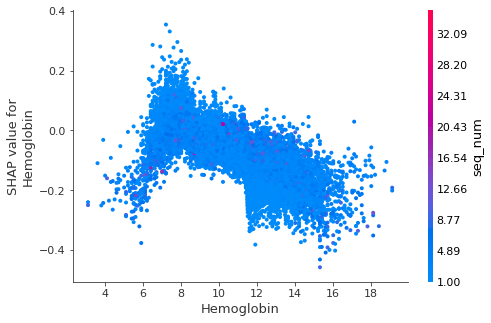

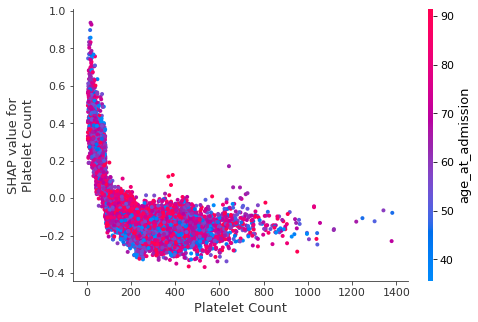

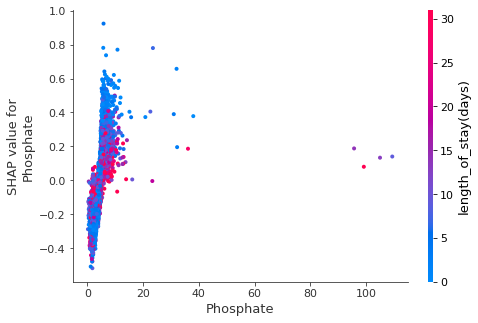

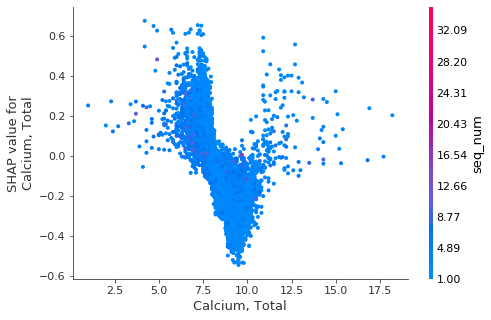

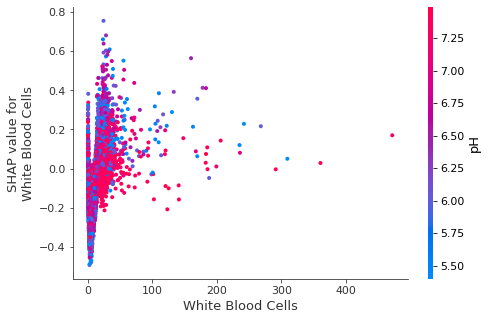

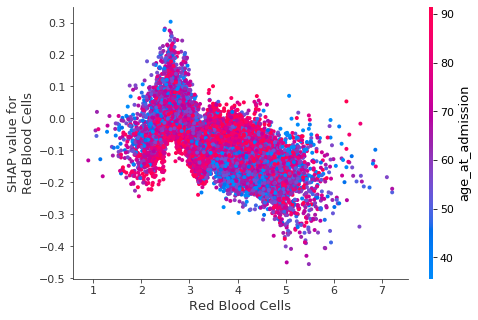

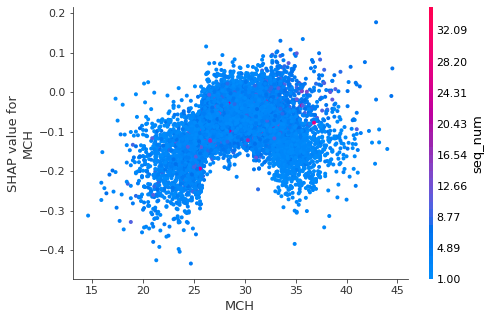

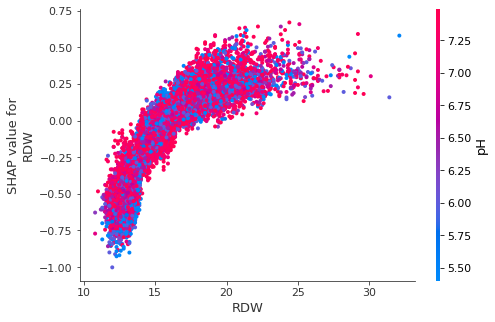

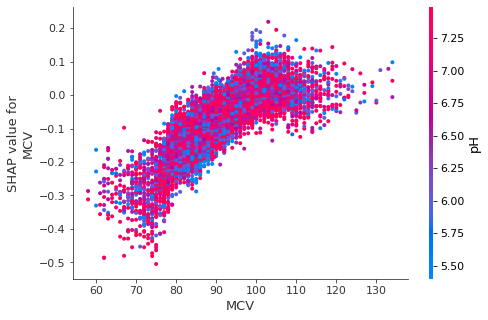

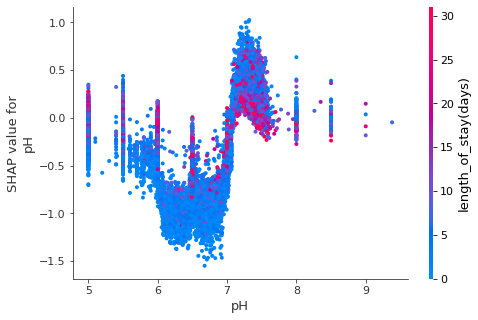

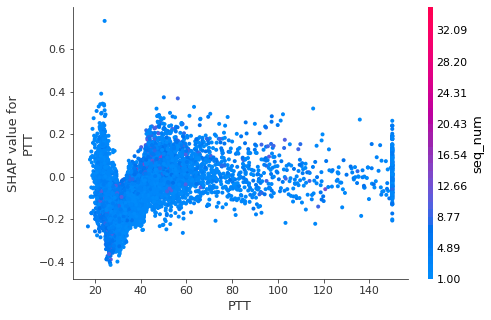

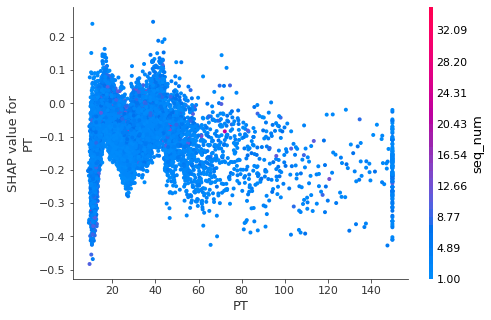

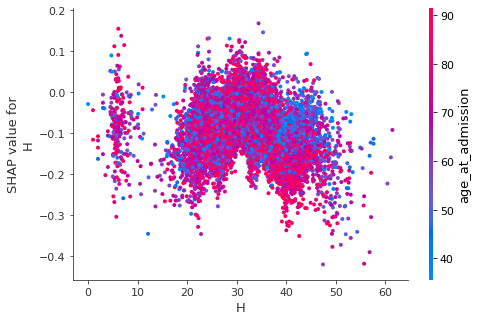

In [6]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names)

# CatBoost

In [9]:
CB_classifier = CatBoostClassifier(
     cat_features=cat_features_indices,
     verbose=False,
     early_stopping_rounds=50,
)
CB_params = {
        'learning_rate': [0.05, 0.1],
        'depth': [4,5,6,7,8,9],
        'l2_leaf_reg': [1, 3, 5, 7, 8],
        'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))

} 
# Note Attention: (ignore, affects speed(not result quality))
# Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
model = strat_cv_it(CB_classifier ,CB_params,True,25)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 23.4min finished


0.8249471832374115

{'scale_pos_weight': 11, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'depth': 4}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      132.053402      3.619709         0.958436        0.087143   
1       37.680198      0.901532         0.907905        0.246695   
2       37.354404      0.451790         0.737693        0.010813   
3      131.116306      1.352238         1.155908        0.037164   
4      132.899160      1.231281         1.023262        0.141403   
5       30.510380      0.604265         0.780911        0.065950   
6       34.648642      1.830039         0.991681        0.100271   
7       41.351045      0.510826         0.724063        0.113269   
8       26.277703      0.269926         0.767613        0.121397   
9      135.512482      0.779426         0.735699        0.262743   
10      56.287089      1.855102         0.827121        0.084034   
11      28.011066      1.846975         0.843078        0.108822   
12      35.294582      1.052897         0.813158        0.032414   
13     135.175051      1.191487         0.819142        0.198638   
14      60.347893      1.503644         0.769608        0.097747   
15      54.455323      1.483258         0.775592        0.158818   
16      26.326239      0.667947         0.832107        0.115353   
17      42.259283      0.524614         0.796536        0.116448   
18      90.052762      0.854585         0.956441        0.292475   
19     141.402060      0.795852         1.044208        0.124766   
20     138.523759      2.582956         0.956774        0.009851   
21      30.014706      1.311987         0.698132        0.036789   
22      89.475305      1.664565         0.802520        0.070547   
23      40.115019      0.219580         0.869674        0.106887   
24      69.317564      3.635589         0.442815        0.168170   

   param_scale_pos_weight param_learning_rate param_l2_leaf_reg param_depth  \
0                      12                0.05                 3           9   
1                      21                 0.1                 8           6   
2                      22                 0.1                 1           6   
3                      21                 0.1                 5           9   
4                      19                 0.1                 7           9   
5                      13                0.05                 7           5   
6                      15                 0.1                 3           5   
7                      22                0.05                 1           6   
8                      14                 0.1                 5           4   
9                      22                0.05                 5           9   
10                      8                0.05                 7           7   
11                     11                0.05                 5           4   
12                     18                 0.1                 3           5   
13                     19                 0.1                 8           9   
14                     14                0.05                 7           7   
15                     22                 0.1                 3           7   
16                     22                 0.1                 1           4   
17                      8                 0.1                 8           6   
18                      9                 0.1                 8           8   
19                     20                0.05                 7           9   
20                      9                 0.1                 7           9   
21                     16                 0.1                 7           4   
22                      8                0.05                 7           8   
23                     14                 0.1                 1           6   
24                      8                 0.1                 5           8   

                                               params  split0_test_score  \
0   {'scale_pos_weight': 12, 'learning_rate': 0.05...           0.823604   
1   {'scale_pos_weight': 21,

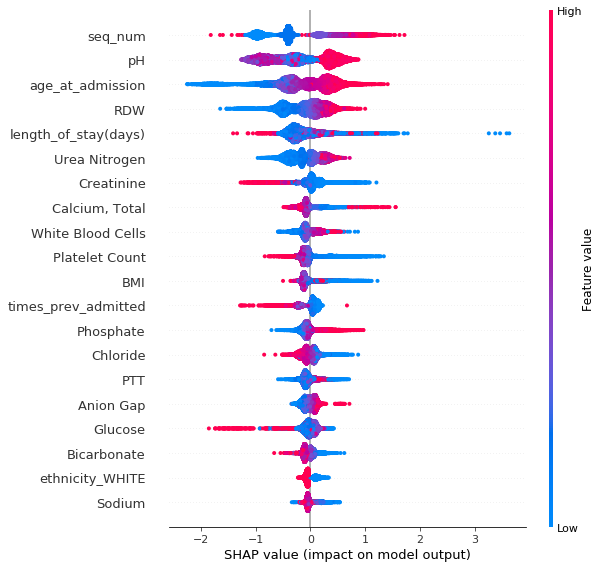

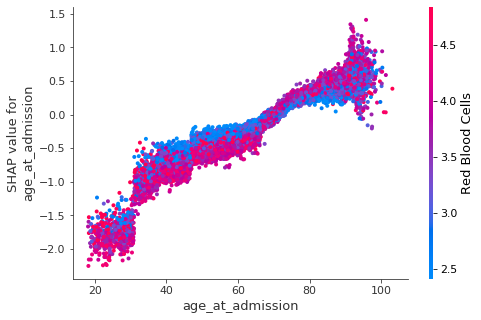

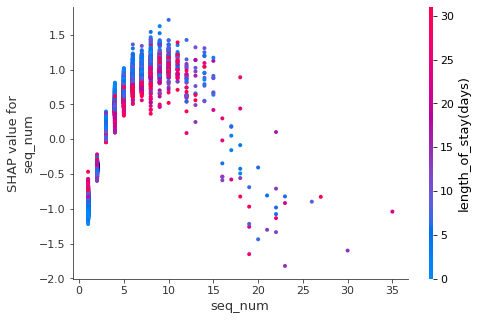

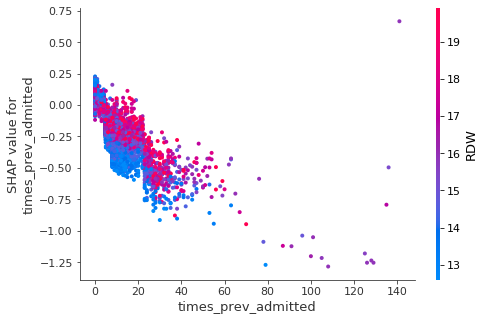

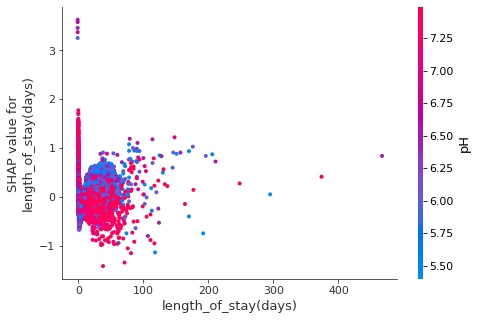

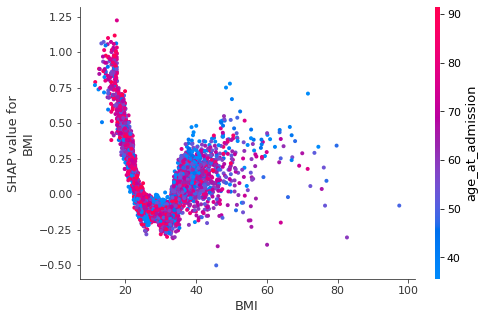

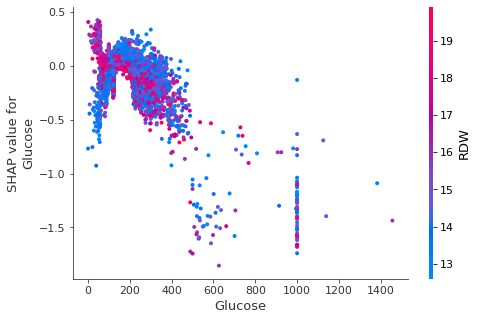

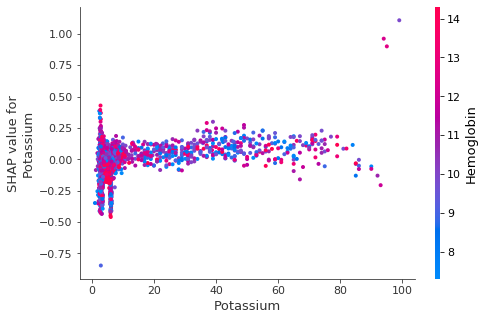

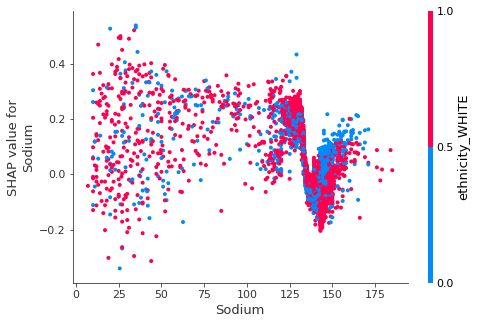

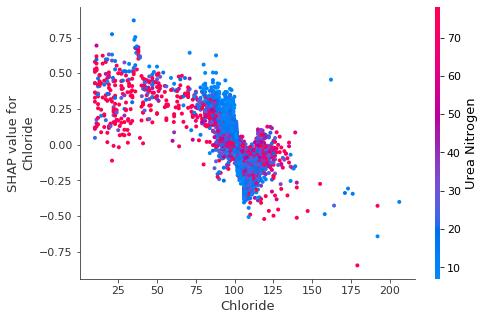

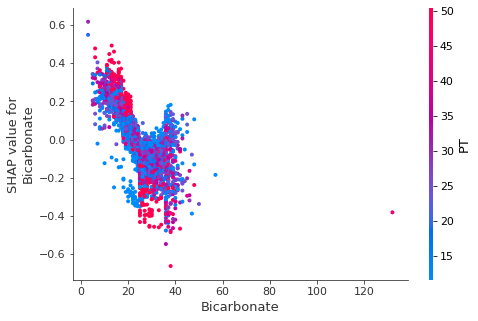

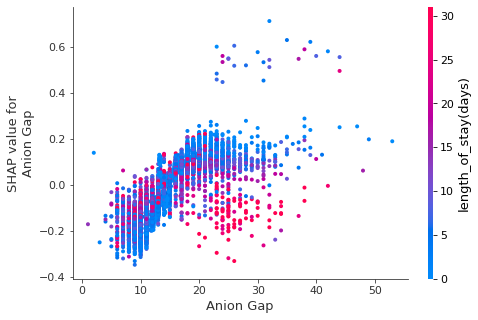

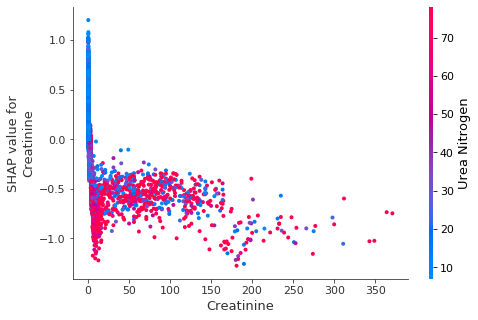

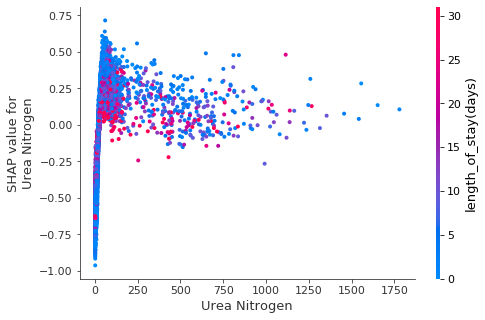

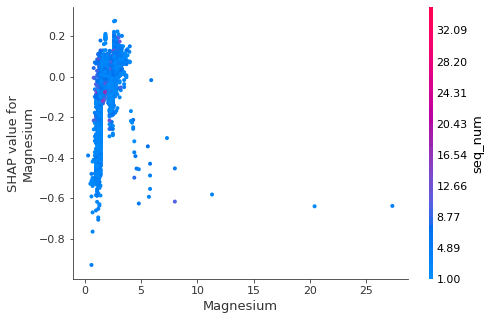

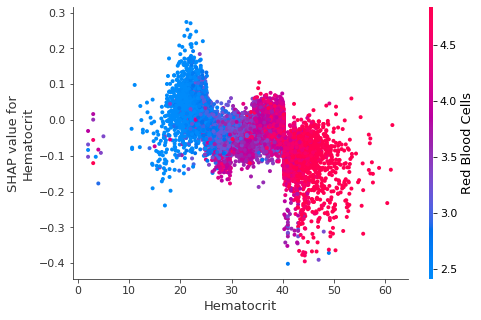

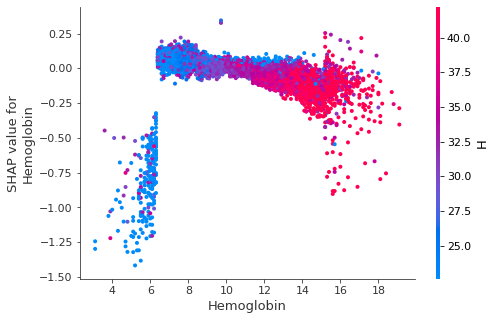

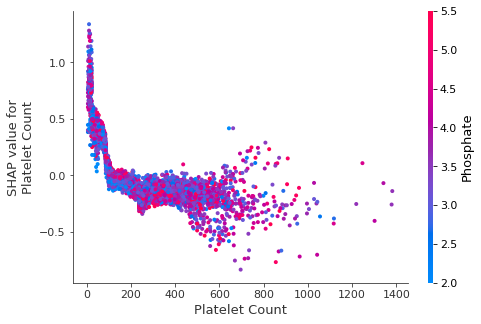

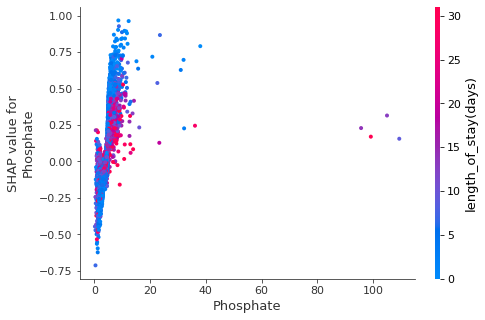

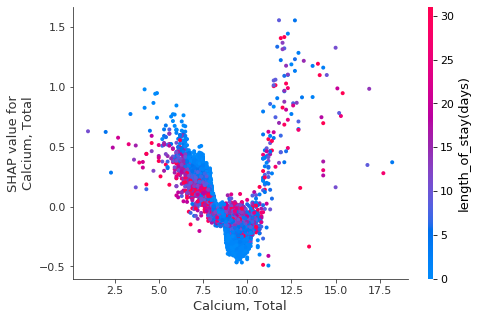

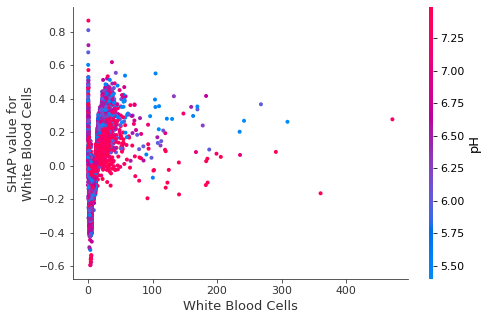

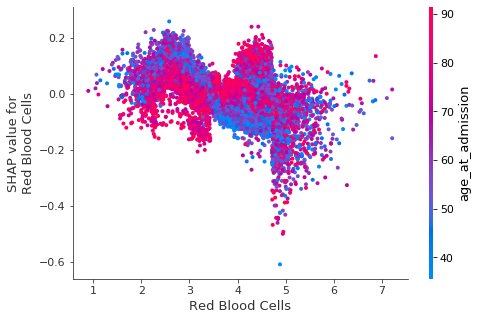

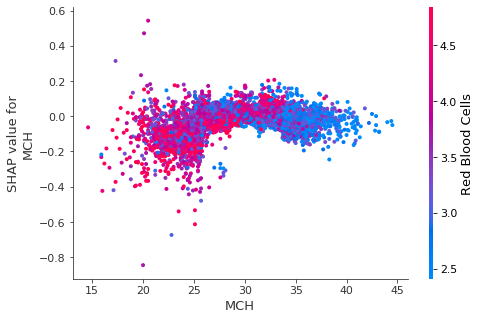

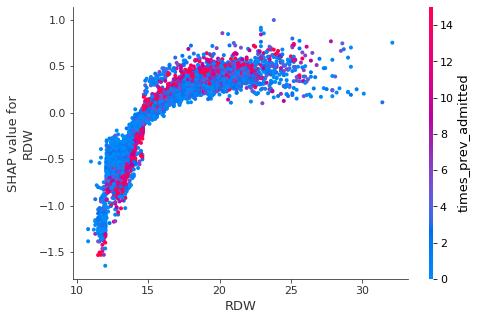

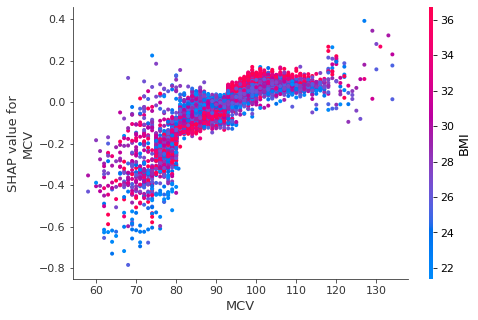

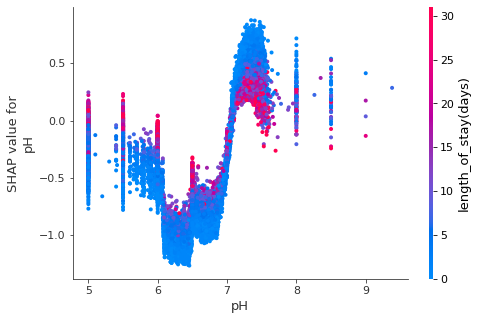

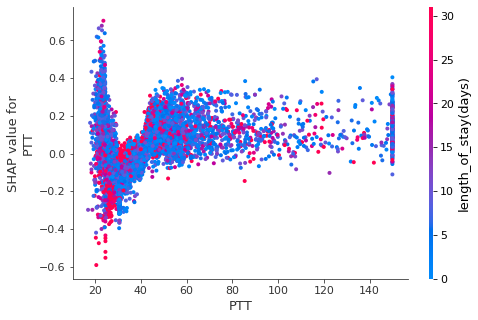

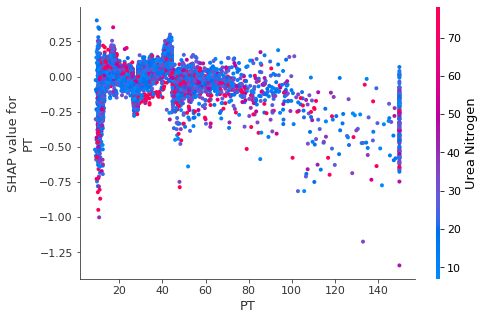

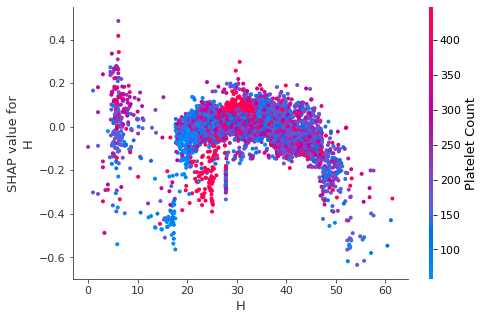

In [10]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values, dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values ,dataset_no_target ,feature_names=feature_names)

# LightGBM

In [7]:
LGB_classifier = lgb.LGBMClassifier()
LGB_params = {
             'num_leaves': [1,5,8,10,15,20,35,40], 
             'min_child_samples': [1,5,10,20,50,100,200,300,400,500], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': [0.2,0,4,0.5, 0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))

}
model = strat_cv_it(LGB_classifier ,LGB_params,True,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.1min finished


0.831837545478192

{'subsample': 1.0,
 'scale_pos_weight': 11,
 'reg_lambda': 100,
 'reg_alpha': 0,
 'num_leaves': 10,
 'min_child_weight': 10.0,
 'min_child_samples': 50,
 'colsample_bytree': 0.6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.055851      0.000814         0.000000        0.000000   
1        0.209108      0.002350         0.028257        0.000471   
2        0.262312      0.002939         0.054191        0.000485   
3        0.053856      0.000814         0.000000        0.000000   
4        0.327132      0.003728         0.061172        0.001244   
5        0.280929      0.001702         0.053849        0.000009   
6        0.616680      0.017260         0.095744        0.002821   
7        0.264957      0.007566         0.057174        0.002486   
8        0.054837      0.000806         0.000000        0.000000   
9        0.054854      0.000814         0.000000        0.000000   
10       0.371015      0.002928         0.059846        0.000813   
11       0.055500      0.000472         0.000000        0.000000   
12       0.277930      0.000949         0.051868        0.000009   
13       0.404598      0.002356         0.067486        0.000470   
14       0.394936      0.002165         0.067167        0.001235   
15       0.055511      0.000479         0.000000        0.000000   
16       0.300861      0.005990         0.059834        0.007773   
17       0.386965      0.005085         0.089753        0.008815   
18       0.425190      0.064150         0.095751        0.033440   
19       0.055178      0.001251         0.000000        0.000000   
20       0.055519      0.003084         0.000000        0.000000   
21       0.418882      0.003735         0.080449        0.000468   
22       0.797195      0.025536         0.085784        0.002161   
23       0.057513      0.003761         0.000000        0.000000   
24       0.055179      0.000950         0.000000        0.000000   
25       0.404925      0.020449         0.067824        0.000022   
26       0.258316      0.001419         0.053517        0.000466   
27       0.404265      0.004479         0.072792        0.000806   
28       0.055518      0.001244         0.000000        0.000000   
29       0.313155      0.019554         0.053191        0.000940   
30       0.832772      0.064885         0.103058        0.004178   
31       0.321805      0.038215         0.057845        0.003550   
32       0.076456      0.019826         0.000000        0.000000   
33       0.309831      0.007706         0.069813        0.005340   
34       0.055510      0.003088         0.000000        0.000000   
35       0.054850      0.002163         0.000000        0.000000   
36       0.382975      0.002155         0.075465        0.001695   
37       0.053190      0.000471         0.000000        0.000000   
38       0.375335      0.050154         0.069484        0.001694   
39       0.063497      0.006925         0.000000        0.000000   
40       0.980716      0.076442         0.094740        0.002161   
41       0.392283      0.048616         0.068151        0.008318   
42       0.498327      0.105426         0.070811        0.006360   
43       0.053849      0.000806         0.000000        0.000000   
44       0.055505      0.000474         0.000000        0.000000   
45       0.054521      0.000470         0.000000        0.000000   
46       0.055186      0.000470         0.000000        0.000000   
47       0.267950      0.000471         0.053211        0.000469   
48       0.054514      0.000931         0.000000        0.000000   
49       0.466753      0.004216         0.088110        0.002048   

   param_subsample param_scale_pos_weight param_reg_lambda param_reg_alpha  \
0                0                     19               10              50   
1              0.2                     20               10             0.1   
2              0.8                     20               50               0   
3                1                     20              0.1              50   
4              0.8                     22                0               0   
5              0.8                     19               20         

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


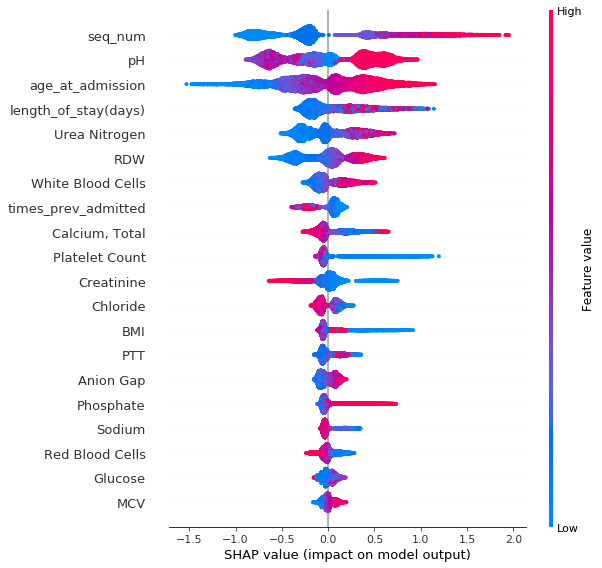

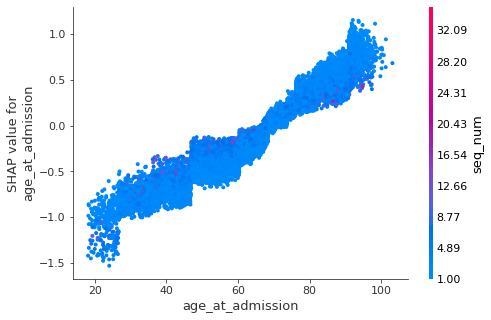

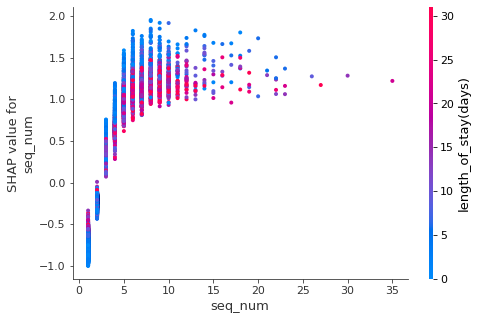

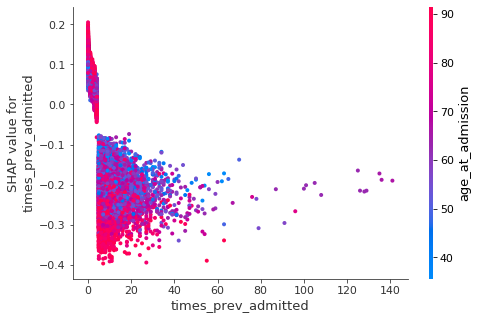

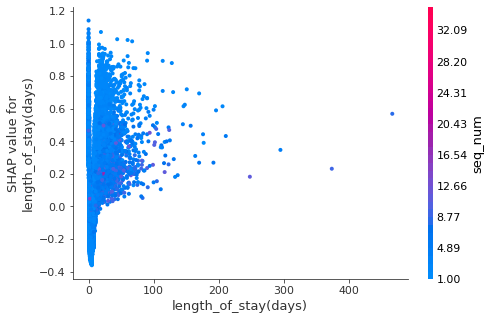

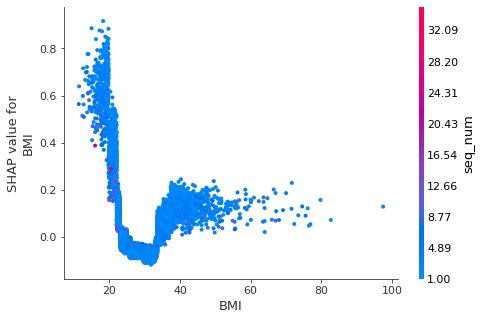

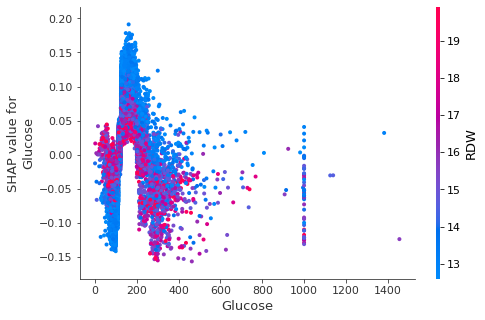

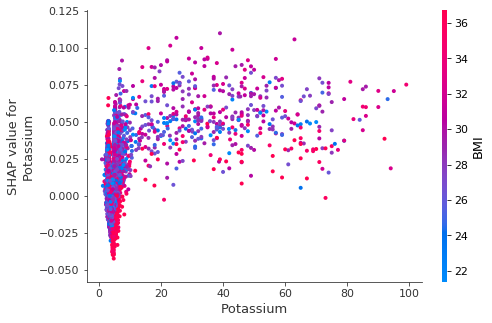

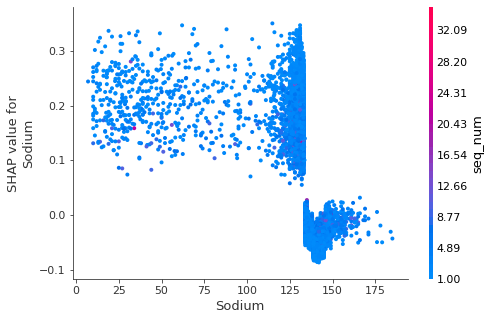

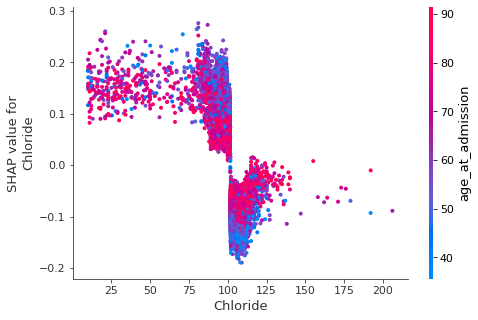

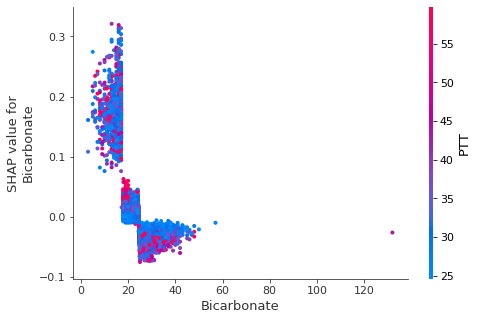

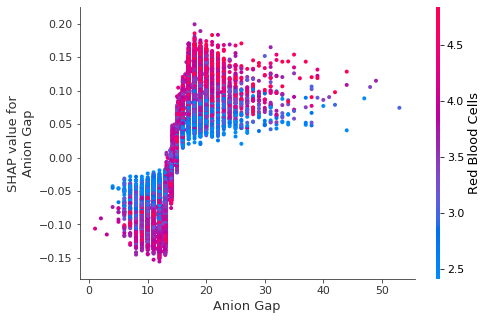

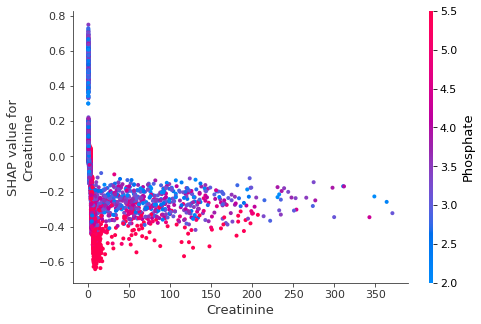

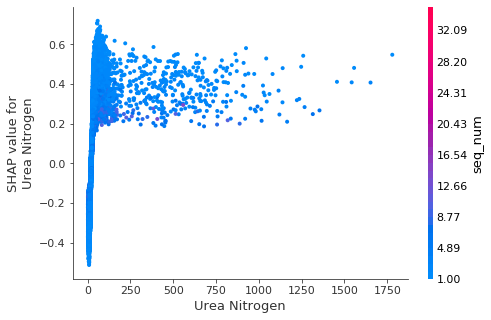

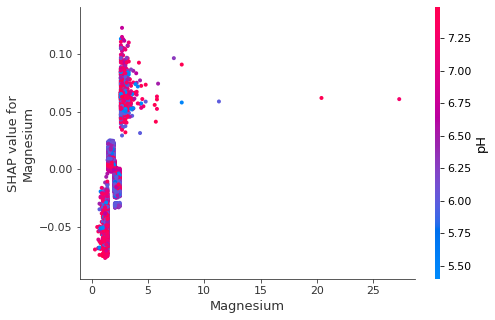

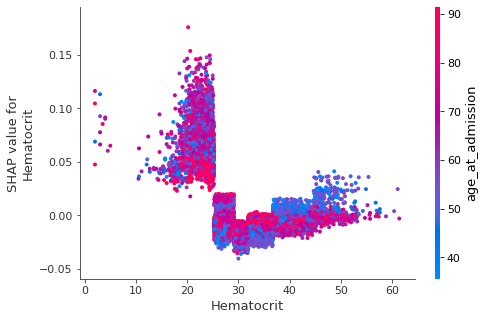

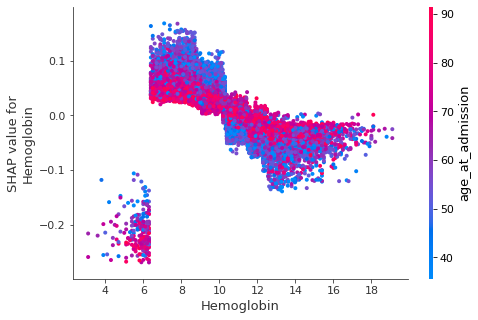

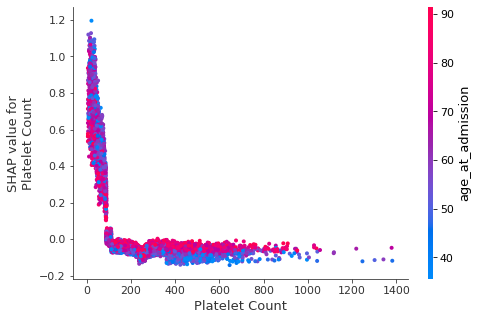

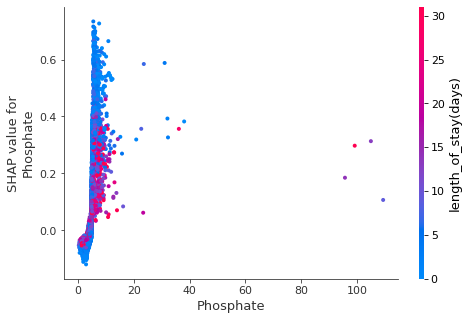

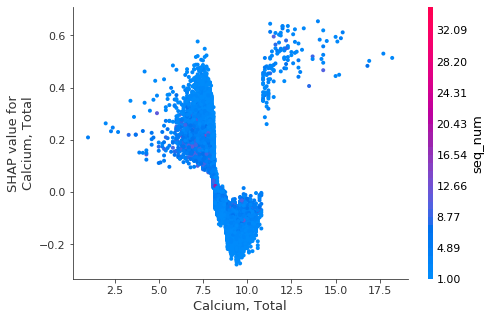

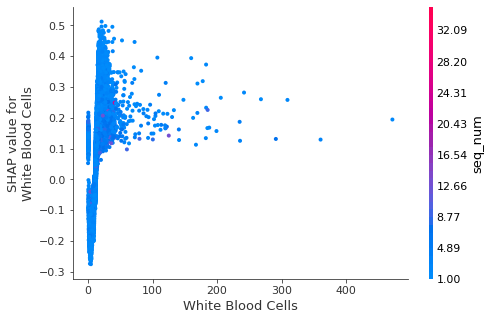

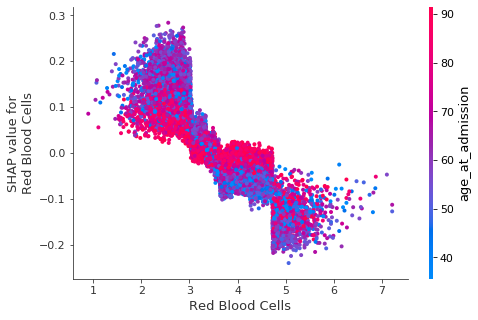

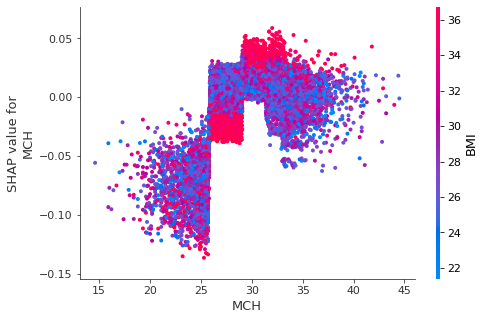

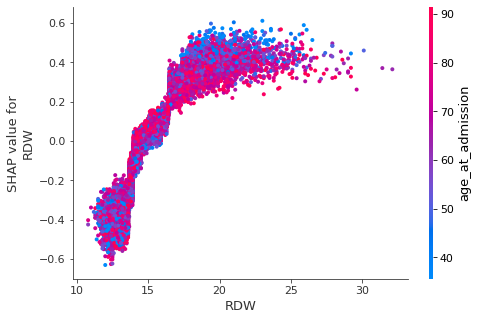

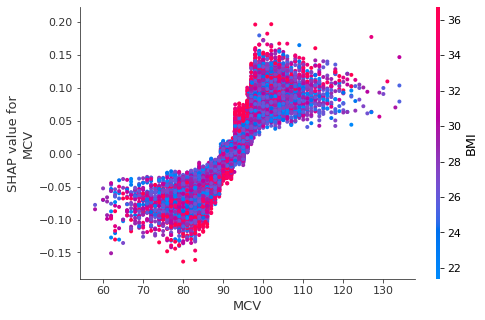

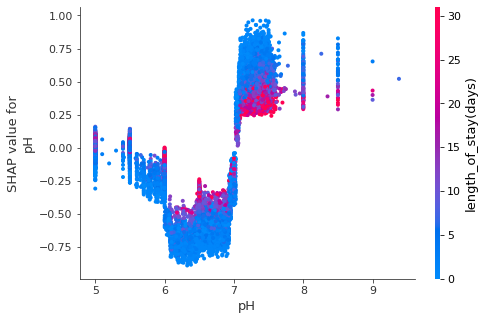

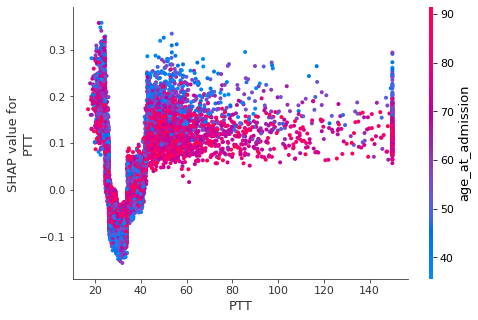

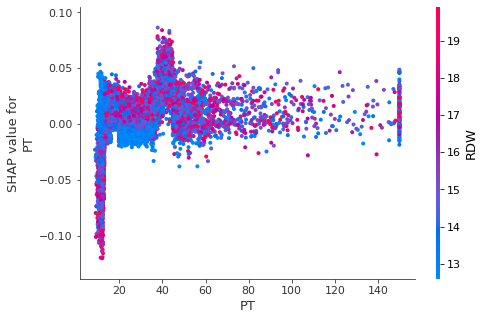

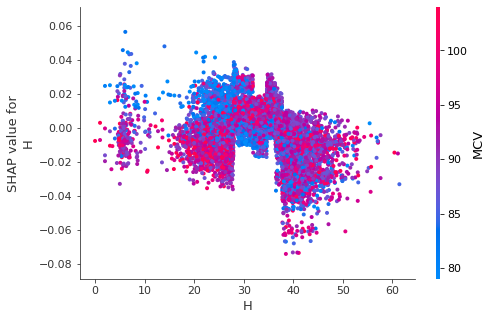

In [8]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values[1], dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1] ,dataset_no_target ,feature_names=feature_names)